# 사용자 행동 인식 데이터 세트

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음. 이를 DataFrame으로 로드.
feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])

# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [2]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [3]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x : x[0]+'-'+str(x[1]) if x[1]>0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop('index',axis=1)
    return new_feature_name_df

In [4]:
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 feature명을 새롭게 수정하는 get_new_feature_name_df()를 이용하여 새로운 feature명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [5]:
print('## 학습 피처 데이터셋 info()')
print(X_train.info())

## 학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [6]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 예제 반복 시마다 동일한 예측 결과 도출을 위해 random_state 설정
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

# DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n',dt_clf.get_params())

결정 트리 예측 정확도: 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 156, 'splitter': 'best'}


In [8]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [6,8,10,12,16,20,24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.5min finished


GridSearchCV 최고 평균 정확도 수치: 0.8513
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 16}


In [9]:
# GridSearchCV 객체의 cv_results_ 속성을 DataFrame으로 생성.
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth 파라미터 값과 그때의 테스트 세트, 학습 데이터 세트의 정확도 수치 추출
cv_results_df[['param_max_depth','mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.850791
1,8,0.851069
2,10,0.851209
3,12,0.844135
4,16,0.851344
5,20,0.850800
6,24,0.849440


In [10]:
max_depths = [6,8,10,12,16,20,24]
# max_depths 값을 변화시키면서 그때마다 학습과 테스트 세트에서의 예측 성능 측정
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=156)
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print('max_depth = {0} 정확도: {1:.4f}'.format(depth, accuracy))

max_depth = 6 정확도: 0.8558
max_depth = 8 정확도: 0.8707
max_depth = 10 정확도: 0.8673
max_depth = 12 정확도: 0.8646
max_depth = 16 정확도: 0.8575
max_depth = 20 정확도: 0.8548
max_depth = 24 정확도: 0.8548


In [11]:
params = {
    'max_depth':[8,12,16,20],
    'min_samples_split':[16,24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train,y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.8min finished


GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


In [12]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred1)
print('결정 트리 예측 정확도:{0:.4f}'.format(accuracy))

결정 트리 예측 정확도:0.8717


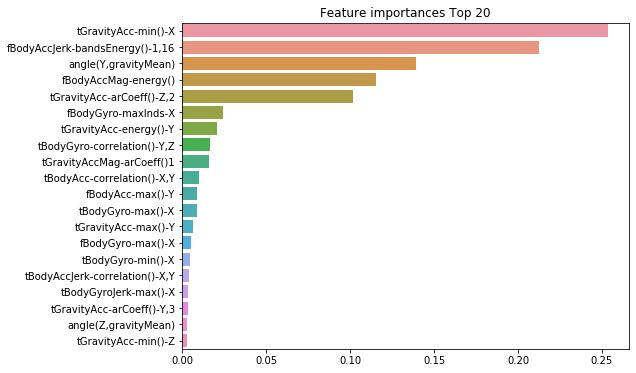

In [13]:
import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_
# Top 중요도로 정렬을 쉽게 하고, 시본(Seaborn)의 막대그래프로 쉽게 표현하기 위해 Series 변환
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
# 중요도값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y = ftr_top20.index)
plt.show()

# 캐글 산탄데르 고객 만족 예측

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv("./santander-customer-satisfaction/train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [15]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [17]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format(unsatisfied_cnt / total_cnt))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [18]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [19]:
# var3 피처 값 대체 및 ID 피처 드롭
cust_df['var3'].replace(-999999,2, inplace=True)
cust_df.drop('ID',axis=1 , inplace=True)

# 피처 세트와 레이블 세트분리. 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [21]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정. 
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행. 
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82005	validation_1-auc:0.81157
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.83400	validation_1-auc:0.82452
[2]	validation_0-auc:0.83870	validation_1-auc:0.82746
[3]	validation_0-auc:0.84419	validation_1-auc:0.82922
[4]	validation_0-auc:0.84783	validation_1-auc:0.83298
[5]	validation_0-auc:0.85125	validation_1-auc:0.83500
[6]	validation_0-auc:0.85501	validation_1-auc:0.83653
[7]	validation_0-auc:0.85830	validation_1-auc:0.83782
[8]	validation_0-auc:0.86143	validation_1-auc:0.83802
[9]	validation_0-auc:0.86452	validation_1-auc:0.83914
[10]	validation_0-auc:0.86717	validation_1-auc:0.83954
[11]	validation_0-auc:0.87013	validation_1-auc:0.83983
[12]	validation_0-auc:0.87369	validation_1-auc:0.84033
[13]	validation_0-auc:0.87620	validation_1-auc:0.84054
[14]	validation_0-auc:0.87799	validation_1-auc:0.84135
[15]	validation_0-auc:0.880

In [22]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5,7] , 'min_child_weight':[1,3] ,'colsample_bytree':[0.5, 0.75] }

# 하이퍼 파라미터 테스트의 수행속도를 향상 시키기 위해 cv를 지정하지 않음. 
gridcv = GridSearchCV(xgb_clf, param_grid=params)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:',gridcv.best_params_) 

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.72255	validation_1-auc:0.72640
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.74625	validation_1-auc:0.75051
[2]	validation_0-auc:0.81675	validation_1-auc:0.81906
[3]	validation_0-auc:0.82734	validation_1-auc:0.82620
[4]	validation_0-auc:0.83559	validation_1-auc:0.83410
[5]	validation_0-auc:0.83854	validation_1-auc:0.83449
[6]	validation_0-auc:0.83653	validation_1-auc:0.83319
[7]	validation_0-auc:0.84281	validation_1-auc:0.83717
[8]	validation_0-auc:0.84240	validation_1-auc:0.83435
[9]	validation_0-auc:0.84139	validation_1-auc:0.83315
[10]	validation_0-auc:0.84795	validation_1-auc:0.83874
[11]	validation_0-auc:0.85114	validation_1-auc:0.84039
[12]	validation_0-auc:0.85300	validation_1-auc:0.84080
[13]	validation_0-auc:0.85371	validation_1-auc:0.84205
[14]	validation_0-auc:0.85534	validation_1-auc:0.84046
[15]	validation_0-auc:0.8583

[41]	validation_0-auc:0.88263	validation_1-auc:0.84030
[42]	validation_0-auc:0.88375	validation_1-auc:0.83969
Stopping. Best iteration:
[12]	validation_0-auc:0.85578	validation_1-auc:0.84339

[0]	validation_0-auc:0.70172	validation_1-auc:0.71158
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.73534	validation_1-auc:0.74277
[2]	validation_0-auc:0.81703	validation_1-auc:0.81887
[3]	validation_0-auc:0.82942	validation_1-auc:0.82872
[4]	validation_0-auc:0.83715	validation_1-auc:0.83600
[5]	validation_0-auc:0.84120	validation_1-auc:0.83456
[6]	validation_0-auc:0.84035	validation_1-auc:0.83646
[7]	validation_0-auc:0.84565	validation_1-auc:0.83754
[8]	validation_0-auc:0.84537	validation_1-auc:0.83804
[9]	validation_0-auc:0.84352	validation_1-auc:0.83600
[10]	validation_0-auc:0.84964	validation_1-auc:0.84041
[11]	validation_0-auc:0.85322	validation_1-auc:0.84252
[

[48]	validation_0-auc:0.87944	validation_1-auc:0.83992
Stopping. Best iteration:
[18]	validation_0-auc:0.86317	validation_1-auc:0.84350

[0]	validation_0-auc:0.70779	validation_1-auc:0.71610
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.73759	validation_1-auc:0.74109
[2]	validation_0-auc:0.81661	validation_1-auc:0.81699
[3]	validation_0-auc:0.82893	validation_1-auc:0.82693
[4]	validation_0-auc:0.83925	validation_1-auc:0.83530
[5]	validation_0-auc:0.84113	validation_1-auc:0.83429
[6]	validation_0-auc:0.83799	validation_1-auc:0.83587
[7]	validation_0-auc:0.84605	validation_1-auc:0.83828
[8]	validation_0-auc:0.84472	validation_1-auc:0.83692
[9]	validation_0-auc:0.84182	validation_1-auc:0.83535
[10]	validation_0-auc:0.85005	validation_1-auc:0.84039
[11]	validation_0-auc:0.85399	validation_1-auc:0.84213
[12]	validation_0-auc:0.85670	validation_1-auc:0.84097
[

[38]	validation_0-auc:0.87614	validation_1-auc:0.83984
[39]	validation_0-auc:0.87658	validation_1-auc:0.83942
[40]	validation_0-auc:0.87703	validation_1-auc:0.83897
[41]	validation_0-auc:0.87718	validation_1-auc:0.83891
[42]	validation_0-auc:0.87790	validation_1-auc:0.83892
[43]	validation_0-auc:0.87804	validation_1-auc:0.83881
[44]	validation_0-auc:0.87842	validation_1-auc:0.83881
[45]	validation_0-auc:0.87857	validation_1-auc:0.83855
[46]	validation_0-auc:0.87863	validation_1-auc:0.83853
[47]	validation_0-auc:0.87920	validation_1-auc:0.83911
[48]	validation_0-auc:0.87930	validation_1-auc:0.83866
[49]	validation_0-auc:0.87971	validation_1-auc:0.83827
[50]	validation_0-auc:0.87984	validation_1-auc:0.83808
[51]	validation_0-auc:0.88001	validation_1-auc:0.83822
[52]	validation_0-auc:0.88027	validation_1-auc:0.83823
[53]	validation_0-auc:0.88041	validation_1-auc:0.83811
Stopping. Best iteration:
[23]	validation_0-auc:0.86607	validation_1-auc:0.84256

[0]	validation_0-auc:0.72303	validatio

[24]	validation_0-auc:0.89195	validation_1-auc:0.84182
[25]	validation_0-auc:0.89327	validation_1-auc:0.83993
[26]	validation_0-auc:0.89372	validation_1-auc:0.83927
[27]	validation_0-auc:0.89505	validation_1-auc:0.83883
[28]	validation_0-auc:0.89662	validation_1-auc:0.83868
[29]	validation_0-auc:0.89759	validation_1-auc:0.83812
[30]	validation_0-auc:0.89822	validation_1-auc:0.83830
[31]	validation_0-auc:0.89829	validation_1-auc:0.83824
[32]	validation_0-auc:0.89898	validation_1-auc:0.83902
[33]	validation_0-auc:0.90013	validation_1-auc:0.83932
[34]	validation_0-auc:0.90069	validation_1-auc:0.83891
[35]	validation_0-auc:0.90096	validation_1-auc:0.83863
[36]	validation_0-auc:0.90161	validation_1-auc:0.83886
[37]	validation_0-auc:0.90197	validation_1-auc:0.83875
[38]	validation_0-auc:0.90309	validation_1-auc:0.83860
[39]	validation_0-auc:0.90383	validation_1-auc:0.83779
[40]	validation_0-auc:0.90393	validation_1-auc:0.83754
[41]	validation_0-auc:0.90432	validation_1-auc:0.83772
[42]	valid

[26]	validation_0-auc:0.89677	validation_1-auc:0.83969
[27]	validation_0-auc:0.89796	validation_1-auc:0.83950
[28]	validation_0-auc:0.89979	validation_1-auc:0.83893
[29]	validation_0-auc:0.90102	validation_1-auc:0.83846
[30]	validation_0-auc:0.90159	validation_1-auc:0.83900
[31]	validation_0-auc:0.90204	validation_1-auc:0.83901
[32]	validation_0-auc:0.90281	validation_1-auc:0.83883
[33]	validation_0-auc:0.90300	validation_1-auc:0.83872
[34]	validation_0-auc:0.90440	validation_1-auc:0.83896
[35]	validation_0-auc:0.90448	validation_1-auc:0.83891
[36]	validation_0-auc:0.90469	validation_1-auc:0.83906
[37]	validation_0-auc:0.90504	validation_1-auc:0.83877
[38]	validation_0-auc:0.90515	validation_1-auc:0.83895
[39]	validation_0-auc:0.90541	validation_1-auc:0.83862
[40]	validation_0-auc:0.90560	validation_1-auc:0.83833
[41]	validation_0-auc:0.90596	validation_1-auc:0.83861
[42]	validation_0-auc:0.90637	validation_1-auc:0.83847
[43]	validation_0-auc:0.90649	validation_1-auc:0.83858
[44]	valid

[17]	validation_0-auc:0.88018	validation_1-auc:0.84161
[18]	validation_0-auc:0.88223	validation_1-auc:0.84168
[19]	validation_0-auc:0.88278	validation_1-auc:0.84094
[20]	validation_0-auc:0.88434	validation_1-auc:0.84057
[21]	validation_0-auc:0.88545	validation_1-auc:0.84101
[22]	validation_0-auc:0.88590	validation_1-auc:0.84073
[23]	validation_0-auc:0.88642	validation_1-auc:0.84059
[24]	validation_0-auc:0.88661	validation_1-auc:0.84008
[25]	validation_0-auc:0.88823	validation_1-auc:0.83975
[26]	validation_0-auc:0.88880	validation_1-auc:0.83958
[27]	validation_0-auc:0.88982	validation_1-auc:0.84026
[28]	validation_0-auc:0.89049	validation_1-auc:0.83981
[29]	validation_0-auc:0.89108	validation_1-auc:0.83905
[30]	validation_0-auc:0.89208	validation_1-auc:0.83846
[31]	validation_0-auc:0.89228	validation_1-auc:0.83814
[32]	validation_0-auc:0.89260	validation_1-auc:0.83776
[33]	validation_0-auc:0.89343	validation_1-auc:0.83830
[34]	validation_0-auc:0.89426	validation_1-auc:0.83818
[35]	valid

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.74495	validation_1-auc:0.75133
[2]	validation_0-auc:0.81633	validation_1-auc:0.81723
[3]	validation_0-auc:0.82915	validation_1-auc:0.82745
[4]	validation_0-auc:0.83624	validation_1-auc:0.83264
[5]	validation_0-auc:0.83963	validation_1-auc:0.83414
[6]	validation_0-auc:0.83815	validation_1-auc:0.82965
[7]	validation_0-auc:0.84439	validation_1-auc:0.83419
[8]	validation_0-auc:0.84341	validation_1-auc:0.83116
[9]	validation_0-auc:0.84359	validation_1-auc:0.82939
[10]	validation_0-auc:0.85194	validation_1-auc:0.83486
[11]	validation_0-auc:0.85602	validation_1-auc:0.83763
[12]	validation_0-auc:0.85961	validation_1-auc:0.83876
[13]	validation_0-auc:0.86073	validation_1-auc:0.83744
[14]	validation_0-auc:0.86287	validation_1-auc:0.83787
[15]	validation_0-auc:0.86419	validation_1-auc:0.83930
[16]	validation_0-auc:0.86628	validation_1-auc:0.84008
[17]	validation_0-auc:0.86730	validation_1-auc:0.83991
[18]	valid

[46]	validation_0-auc:0.88530	validation_1-auc:0.83583
[47]	validation_0-auc:0.88539	validation_1-auc:0.83598
Stopping. Best iteration:
[17]	validation_0-auc:0.86698	validation_1-auc:0.84250

[0]	validation_0-auc:0.71318	validation_1-auc:0.71927
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.74184	validation_1-auc:0.74329
[2]	validation_0-auc:0.81698	validation_1-auc:0.82083
[3]	validation_0-auc:0.82941	validation_1-auc:0.83071
[4]	validation_0-auc:0.83605	validation_1-auc:0.83412
[5]	validation_0-auc:0.84178	validation_1-auc:0.83724
[6]	validation_0-auc:0.83924	validation_1-auc:0.83371
[7]	validation_0-auc:0.84603	validation_1-auc:0.83662
[8]	validation_0-auc:0.84538	validation_1-auc:0.83501
[9]	validation_0-auc:0.84484	validation_1-auc:0.83323
[10]	validation_0-auc:0.85075	validation_1-auc:0.83548
[11]	validation_0-auc:0.85411	validation_1-auc:0.83836
[

[46]	validation_0-auc:0.88034	validation_1-auc:0.83664
[47]	validation_0-auc:0.88060	validation_1-auc:0.83635
Stopping. Best iteration:
[17]	validation_0-auc:0.86356	validation_1-auc:0.83957

[0]	validation_0-auc:0.73769	validation_1-auc:0.74321
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.75397	validation_1-auc:0.75921
[2]	validation_0-auc:0.81954	validation_1-auc:0.81718
[3]	validation_0-auc:0.83458	validation_1-auc:0.83267
[4]	validation_0-auc:0.84066	validation_1-auc:0.83452
[5]	validation_0-auc:0.84281	validation_1-auc:0.83579
[6]	validation_0-auc:0.84235	validation_1-auc:0.83108
[7]	validation_0-auc:0.84896	validation_1-auc:0.83487
[8]	validation_0-auc:0.84819	validation_1-auc:0.83116
[9]	validation_0-auc:0.84748	validation_1-auc:0.83341
[10]	validation_0-auc:0.85338	validation_1-auc:0.83644
[11]	validation_0-auc:0.85716	validation_1-auc:0.83854
[

[39]	validation_0-auc:0.87484	validation_1-auc:0.83810
[40]	validation_0-auc:0.87504	validation_1-auc:0.83817
[41]	validation_0-auc:0.87516	validation_1-auc:0.83794
[42]	validation_0-auc:0.87580	validation_1-auc:0.83816
[43]	validation_0-auc:0.87598	validation_1-auc:0.83789
[44]	validation_0-auc:0.87638	validation_1-auc:0.83786
[45]	validation_0-auc:0.87661	validation_1-auc:0.83781
[46]	validation_0-auc:0.87697	validation_1-auc:0.83755
Stopping. Best iteration:
[16]	validation_0-auc:0.86180	validation_1-auc:0.84189

[0]	validation_0-auc:0.73616	validation_1-auc:0.73830
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.75504	validation_1-auc:0.75641
[2]	validation_0-auc:0.82175	validation_1-auc:0.81927
[3]	validation_0-auc:0.83236	validation_1-auc:0.82923
[4]	validation_0-auc:0.83724	validation_1-auc:0.83086
[5]	validation_0-auc:0.83960	validation_1-auc:0.832

[36]	validation_0-auc:0.90399	validation_1-auc:0.83652
[37]	validation_0-auc:0.90476	validation_1-auc:0.83568
[38]	validation_0-auc:0.90610	validation_1-auc:0.83518
[39]	validation_0-auc:0.90726	validation_1-auc:0.83497
[40]	validation_0-auc:0.90793	validation_1-auc:0.83460
[41]	validation_0-auc:0.90927	validation_1-auc:0.83414
[42]	validation_0-auc:0.90929	validation_1-auc:0.83406
[43]	validation_0-auc:0.90936	validation_1-auc:0.83412
[44]	validation_0-auc:0.90964	validation_1-auc:0.83405
[45]	validation_0-auc:0.91097	validation_1-auc:0.83403
Stopping. Best iteration:
[15]	validation_0-auc:0.88697	validation_1-auc:0.84044

[0]	validation_0-auc:0.74195	validation_1-auc:0.74456
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.76631	validation_1-auc:0.76284
[2]	validation_0-auc:0.82672	validation_1-auc:0.81869
[3]	validation_0-auc:0.84185	validation_1-auc:0.8

[31]	validation_0-auc:0.90327	validation_1-auc:0.83464
[32]	validation_0-auc:0.90340	validation_1-auc:0.83454
[33]	validation_0-auc:0.90376	validation_1-auc:0.83447
[34]	validation_0-auc:0.90388	validation_1-auc:0.83448
[35]	validation_0-auc:0.90583	validation_1-auc:0.83389
[36]	validation_0-auc:0.90702	validation_1-auc:0.83291
[37]	validation_0-auc:0.90717	validation_1-auc:0.83266
[38]	validation_0-auc:0.90729	validation_1-auc:0.83266
[39]	validation_0-auc:0.90767	validation_1-auc:0.83236
[40]	validation_0-auc:0.90853	validation_1-auc:0.83181
[41]	validation_0-auc:0.90878	validation_1-auc:0.83203
[42]	validation_0-auc:0.90906	validation_1-auc:0.83204
[43]	validation_0-auc:0.90912	validation_1-auc:0.83183
[44]	validation_0-auc:0.91019	validation_1-auc:0.83078
[45]	validation_0-auc:0.91100	validation_1-auc:0.83052
[46]	validation_0-auc:0.91182	validation_1-auc:0.83034
[47]	validation_0-auc:0.91186	validation_1-auc:0.83041
[48]	validation_0-auc:0.91331	validation_1-auc:0.83020
[49]	valid

[21]	validation_0-auc:0.88766	validation_1-auc:0.83824
[22]	validation_0-auc:0.88839	validation_1-auc:0.83792
[23]	validation_0-auc:0.88910	validation_1-auc:0.83774
[24]	validation_0-auc:0.88936	validation_1-auc:0.83762
[25]	validation_0-auc:0.88949	validation_1-auc:0.83763
[26]	validation_0-auc:0.89071	validation_1-auc:0.83805
[27]	validation_0-auc:0.89094	validation_1-auc:0.83778
[28]	validation_0-auc:0.89118	validation_1-auc:0.83786
[29]	validation_0-auc:0.89209	validation_1-auc:0.83782
[30]	validation_0-auc:0.89223	validation_1-auc:0.83776
[31]	validation_0-auc:0.89272	validation_1-auc:0.83804
[32]	validation_0-auc:0.89279	validation_1-auc:0.83794
[33]	validation_0-auc:0.89389	validation_1-auc:0.83753
[34]	validation_0-auc:0.89413	validation_1-auc:0.83729
[35]	validation_0-auc:0.89471	validation_1-auc:0.83788
[36]	validation_0-auc:0.89662	validation_1-auc:0.83754
[37]	validation_0-auc:0.89851	validation_1-auc:0.83739
[38]	validation_0-auc:0.89878	validation_1-auc:0.83712
[39]	valid

[11]	validation_0-auc:0.85874	validation_1-auc:0.84140
[12]	validation_0-auc:0.86155	validation_1-auc:0.84268
[13]	validation_0-auc:0.86282	validation_1-auc:0.84208
[14]	validation_0-auc:0.86577	validation_1-auc:0.84310
[15]	validation_0-auc:0.86689	validation_1-auc:0.84319
[16]	validation_0-auc:0.86877	validation_1-auc:0.84306
[17]	validation_0-auc:0.87009	validation_1-auc:0.84299
[18]	validation_0-auc:0.87139	validation_1-auc:0.84242
[19]	validation_0-auc:0.87253	validation_1-auc:0.84214
[20]	validation_0-auc:0.87360	validation_1-auc:0.84176
[21]	validation_0-auc:0.87555	validation_1-auc:0.84094
[22]	validation_0-auc:0.87752	validation_1-auc:0.84060
[23]	validation_0-auc:0.87791	validation_1-auc:0.84078
[24]	validation_0-auc:0.87845	validation_1-auc:0.84102
[25]	validation_0-auc:0.87874	validation_1-auc:0.84125
[26]	validation_0-auc:0.88009	validation_1-auc:0.84105
[27]	validation_0-auc:0.88040	validation_1-auc:0.84118
[28]	validation_0-auc:0.88076	validation_1-auc:0.84081
[29]	valid

In [23]:
# n_estimators는 1000으로 증가시키고, learning_rate=0.02로 감소, reg_alpha=0.03으로 추가함. 
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=5,\
                        min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

# evaluation metric을 auc로, early stopping은 200 으로 설정하고 학습 수행. 
xgb_clf.fit(X_train, y_train, early_stopping_rounds=200, 
            eval_metric="auc",eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.74129	validation_1-auc:0.74595
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.79948	validation_1-auc:0.80358
[2]	validation_0-auc:0.82182	validation_1-auc:0.81683
[3]	validation_0-auc:0.82630	validation_1-auc:0.81910
[4]	validation_0-auc:0.82926	validation_1-auc:0.82104
[5]	validation_0-auc:0.83025	validation_1-auc:0.82133
[6]	validation_0-auc:0.82996	validation_1-auc:0.82105
[7]	validation_0-auc:0.82890	validation_1-auc:0.82109
[8]	validation_0-auc:0.82975	validation_1-auc:0.82161
[9]	validation_0-auc:0.83156	validation_1-auc:0.82326
[10]	validation_0-auc:0.83157	validation_1-auc:0.82346
[11]	validation_0-auc:0.83175	validation_1-auc:0.82353
[12]	validation_0-auc:0.83267	validation_1-auc:0.82493
[13]	validation_0-auc:0.83290	validation_1-auc:0.82515
[14]	validation_0-auc:0.83295	validation_1-auc:0.82503
[15]	validation_0-auc:0.832

[146]	validation_0-auc:0.85662	validation_1-auc:0.84146
[147]	validation_0-auc:0.85681	validation_1-auc:0.84158
[148]	validation_0-auc:0.85695	validation_1-auc:0.84175
[149]	validation_0-auc:0.85711	validation_1-auc:0.84179
[150]	validation_0-auc:0.85718	validation_1-auc:0.84190
[151]	validation_0-auc:0.85720	validation_1-auc:0.84205
[152]	validation_0-auc:0.85742	validation_1-auc:0.84205
[153]	validation_0-auc:0.85747	validation_1-auc:0.84210
[154]	validation_0-auc:0.85765	validation_1-auc:0.84211
[155]	validation_0-auc:0.85785	validation_1-auc:0.84224
[156]	validation_0-auc:0.85791	validation_1-auc:0.84226
[157]	validation_0-auc:0.85800	validation_1-auc:0.84241
[158]	validation_0-auc:0.85816	validation_1-auc:0.84279
[159]	validation_0-auc:0.85828	validation_1-auc:0.84273
[160]	validation_0-auc:0.85837	validation_1-auc:0.84268
[161]	validation_0-auc:0.85856	validation_1-auc:0.84280
[162]	validation_0-auc:0.85873	validation_1-auc:0.84270
[163]	validation_0-auc:0.85899	validation_1-auc:

[293]	validation_0-auc:0.87365	validation_1-auc:0.84362
[294]	validation_0-auc:0.87376	validation_1-auc:0.84357
[295]	validation_0-auc:0.87382	validation_1-auc:0.84361
[296]	validation_0-auc:0.87387	validation_1-auc:0.84364
[297]	validation_0-auc:0.87390	validation_1-auc:0.84367
[298]	validation_0-auc:0.87399	validation_1-auc:0.84372
[299]	validation_0-auc:0.87409	validation_1-auc:0.84372
[300]	validation_0-auc:0.87418	validation_1-auc:0.84370
[301]	validation_0-auc:0.87429	validation_1-auc:0.84371
[302]	validation_0-auc:0.87435	validation_1-auc:0.84368
[303]	validation_0-auc:0.87439	validation_1-auc:0.84377
[304]	validation_0-auc:0.87443	validation_1-auc:0.84376
[305]	validation_0-auc:0.87456	validation_1-auc:0.84373
[306]	validation_0-auc:0.87466	validation_1-auc:0.84373
[307]	validation_0-auc:0.87475	validation_1-auc:0.84377
[308]	validation_0-auc:0.87487	validation_1-auc:0.84378
[309]	validation_0-auc:0.87491	validation_1-auc:0.84378
[310]	validation_0-auc:0.87499	validation_1-auc:

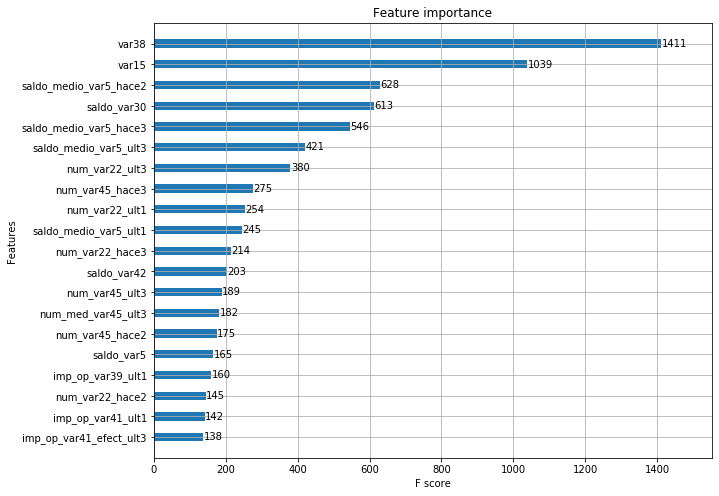

In [26]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)
plt.show()